# pytorch实现seq2seq+attention转换日期
***
使用keras实现加入注意力机制的seq2seq比较麻烦，所以这里我尝试使用机器翻译的seq2seq+attention模型实现人造日期对标准日期格式的转换。


所copy的代码来自[practical-pytorch教程](https://github.com/spro/practical-pytorch/tree/master/seq2seq-translation)，以及[pytorch-seq2seq教程](https://github.com/bentrevett/pytorch-seq2seq)


所用的数据来自[注意力机制keras实现](https://github.com/Choco31415/Attention_Network_With_Keras/tree/master/data)。   
python3   
pytorch版本 0.4.0  
可能需要GPU

In [1]:
import json
from matplotlib import ticker
from numpy import *
from collections import Counter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 预处理 
---
这里先生成字符和数字相互转换的字典，如果是句子也可以按照词为单位。我在字典的开头添加了4种表示。

In [3]:
def build_vocab(texts, n=None):
    counter = Counter(''.join(texts))  # char level
    char2index = {w: i for i, (w, c) in enumerate(counter.most_common(n), start=4)}
    char2index['~'] = 0  # pad  不足长度的文本在后边填充0
    char2index['^'] = 1  # sos  表示句子的开头
    char2index['$'] = 2  # eos  表示句子的结尾
    char2index['#'] = 3  # unk  表示句子中出现的字典中没有的未知词
    index2char = {i: w for w, i in char2index.items()}
    return char2index, index2char

先看一下数据的格式。

In [4]:
pairs = json.load(open('Time Dataset.json', 'rt', encoding='utf-8'))
print(pairs[:1])

[['six hours and fifty five am', '06:55']]


我们将目标文本和原文本分开，求出两边句子的最大长度，然后建立两边各自的字典。

In [5]:
data = array(pairs)
src_texts = data[:, 0]
trg_texts = data[:, 1]
src_c2ix, src_ix2c = build_vocab(src_texts)
trg_c2ix, trg_ix2c = build_vocab(trg_texts)

这里按批量跟新，定义一个随机批量生成的函数，它能够将文本转换成字典中的数字表示，并同时返回batch_size个样本和它们的长度，这些样本按照长度降序排序。pad的长度以batch中最长的为准。这主要是为了适应pack_padded_sequence这个函数，因为输入RNN的序列不需要将pad标志也输入RNN中计算，RNN只需要循环计算到其真实长度即可。

In [6]:
def indexes_from_text(text, char2index):
    return [1] + [char2index[c] for c in text] + [2]  # 手动添加开始结束标志
def pad_seq(seq, max_length):
    seq += [0 for _ in range(max_length - len(seq))]
    return seq

max_src_len = max(list(map(len, src_texts))) + 2
max_trg_len = max(list(map(len, trg_texts))) + 2
max_src_len, max_trg_len

(43, 7)

In [7]:
def random_batch(batch_size, pairs, src_c2ix, trg_c2ix):
    input_seqs, target_seqs = [], []

    for i in random.choice(len(pairs), batch_size):
        input_seqs.append(indexes_from_text(pairs[i][0], src_c2ix))
        target_seqs.append(indexes_from_text(pairs[i][1], trg_c2ix))

    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    input_var = torch.LongTensor(input_padded).transpose(0, 1)  
    # seq_len x batch_size
    target_var = torch.LongTensor(target_padded).transpose(0, 1)
    input_var = input_var.to(device)
    target_var = target_var.to(device)

    return input_var, input_lengths, target_var, target_lengths

可以先打印一下，batch_size=3时的返回结果。注意这里batch经过了转置。

In [8]:
random_batch(3, data, src_c2ix, trg_c2ix)

(tensor([[  1,   1,   1],
         [  6,  18,   6],
         [ 31,  18,  15],
         [  5,   4,  25],
         [ 30,  29,   9],
         [ 28,   5,  26],
         [  5,  12,  26],
         [  4,   7,   2],
         [  7,  10,   0],
         [ 33,   5,   0],
         [ 22,   4,   0],
         [ 30,  23,   0],
         [  7,   4,   0],
         [ 22,  13,   0],
         [ 34,   9,   0],
         [  4,  11,   0],
         [  6,   2,   0],
         [ 16,   0,   0],
         [ 14,   0,   0],
         [ 10,   0,   0],
         [  6,   0,   0],
         [ 20,   0,   0],
         [  4,   0,   0],
         [  5,   0,   0],
         [ 14,   0,   0],
         [ 39,   0,   0],
         [ 16,   0,   0],
         [  6,   0,   0],
         [  4,   0,   0],
         [ 13,   0,   0],
         [  6,   0,   0],
         [  4,   0,   0],
         [ 11,   0,   0],
         [ 14,   0,   0],
         [ 32,   0,   0],
         [  8,   0,   0],
         [ 14,   0,   0],
         [ 39,   0,   0],
         [ 1

## 模型定义
---
模型分为encoder和decoder两个部分，decoder部分比较简单，就是一层Embedding层加上两层GRU。之前处理的batch的格式主要是为了使用pack_padded_sequence和pad_packed_sequence这两个类对GRU输入输出批量处理。一定要注意各个变量的shape。

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, num_layers=2, dropout=0.2):
        super().__init__()

        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        # input_dim = vocab_size + 1
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.rnn = nn.GRU(embedding_dim, hidden_dim,
                          num_layers=num_layers, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seqs, input_lengths, hidden=None):
        # src = [sent len, batch size]
        embedded = self.dropout(self.embedding(input_seqs))

        # embedded = [sent len, batch size, emb dim]
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)

        outputs, hidden = self.rnn(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # outputs, hidden = self.rnn(embedded, hidden)
        # outputs = [sent len, batch size, hid dim * n directions]
        # hidden = [n layers, batch size, hid dim]
        # outputs are always from the last layer
        return outputs, hidden

首先定义一下Attention层，这里主要是对encoder的输出进行attention操作，也可以直接对embedding层的输出进行attention。   
论文[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)中定义了attention的计算公式。 

decoder的输出取决于decoder先前的输出和 $\mathbf x$, 这里 $\mathbf x$ 包括当前GRU输出的hidden state（这部分已经考虑了先前的输出） 以及attention（上下文向量，由encoder的输出求得）。 计算公式如下：函数 $g$ 非线性激活的全连接层，输入是 $y_{i-1}$, $s_i$, and $c_i$ 三者的拼接。

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

所谓的上下文向量就是对encoder的所有输出进行加权求和，$a_{ij}$ 表示输出的第 i 个词对encoder第 j 个输出 $h_j$ 的权重。

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

每个 $a_{ij}$ 通过对所有 $e_{ij}$ 进行softmax，而每个 $e_{ij}$ 是decoder的上一个hidden state $s_{i-1}$ 和指定的encoder的输出 $h_j$ 经过某些线性操作 $a$ 计算得分。

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})} 
\\
e_{ij} = a(s_{i-1}, h_j)
$$

此外，论文[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)中提出了计算分值的不同方式。这里用到的是第三种。

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

In [10]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attn = nn.Linear(self.hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))
        self.v.data.normal_(mean=0, std=1. / np.sqrt(self.v.size(0)))

    def forward(self, hidden, encoder_outputs):
        #  encoder_outputs:(seq_len, batch_size, hidden_size)
        #  hidden:(num_layers * num_directions, batch_size, hidden_size)
        max_len = encoder_outputs.size(0)

        h = hidden[-1].repeat(max_len, 1, 1)
        # (seq_len, batch_size, hidden_size)

        attn_energies = self.score(h, encoder_outputs)  # compute attention score
        return F.softmax(attn_energies, dim=1)  # normalize with softmax

    def score(self, hidden, encoder_outputs):
        # (seq_len, batch_size, 2*hidden_size)-> (seq_len, batch_size, hidden_size)
        energy = F.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.permute(1, 2, 0)  # (batch_size, hidden_size, seq_len)
        v = self.v.repeat(encoder_outputs.size(1), 1).unsqueeze(1)  # (batch_size, 1, hidden_size)
        energy = torch.bmm(v, energy)  # (batch_size, 1, seq_len)
        return energy.squeeze(1)  # (batch_size, seq_len)

下面是加了attention层的decoder，GRU的输出进过全连接层后，又进行了log_softmax操作计算输出词的概率，主要是为了方便NLLLoss损失函数，如果用CrossEntropyLoss损失函数，可以不加log_softmax操作。

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, num_layers=2, dropout=0.2):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.hid_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.attention = Attention(hidden_dim)
        self.rnn = nn.GRU(embedding_dim + hidden_dim, hidden_dim,
                          num_layers=num_layers, dropout=dropout)
        self.out = nn.Linear(embedding_dim + hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [bsz]
        # hidden = [n layers * n directions, batch size, hid dim]
        # encoder_outputs = [sent len, batch size, hid dim * n directions]
        input = input.unsqueeze(0)
        # input = [1, bsz]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, bsz, emb dim]
        attn_weight = self.attention(hidden, encoder_outputs)
        # (batch_size, seq_len)
        context = attn_weight.unsqueeze(1).bmm(encoder_outputs.transpose(0, 1)).transpose(0, 1)
        # (batch_size, 1, hidden_dim * n_directions)
        # (1, batch_size, hidden_dim * n_directions)
        emb_con = torch.cat((embedded, context), dim=2)
        # emb_con = [1, bsz, emb dim + hid dim]
        _, hidden = self.rnn(emb_con, hidden)
        # outputs = [sent len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        output = torch.cat((embedded.squeeze(0), hidden[-1], context.squeeze(0)), dim=1)
        output = F.log_softmax(self.out(output), 1)
        # outputs = [sent len, batch size, vocab_size]
        return output, hidden, attn_weight

我们再定义一个Seq2seq类，将encoder和decoder结合起来，通过一个循环，模型对每一个batch从前往后依次生成序列，训练的时候可以使用teacher_forcing随机使用真实词或是模型输出的词作为target，测试的时候就不需要了。

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.5):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, src_seqs, src_lengths, trg_seqs):
        # src_seqs = [sent len, batch size]
        # trg_seqs = [sent len, batch size]
        batch_size = src_seqs.shape[1]
        max_len = trg_seqs.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        # hidden used as the initial hidden state of the decoder
        # encoder_outputs used to compute context
        encoder_outputs, hidden = self.encoder(src_seqs, src_lengths)
        # first input to the decoder is the <sos> tokens
        output = trg_seqs[0, :]
        for t in range(1, max_len): # skip sos
            output, hidden, _ = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < self.teacher_forcing_ratio
            output = (trg_seqs[t] if teacher_force else output.max(1)[1])
        return outputs
    
    def predict(self, src_seqs, src_lengths, max_trg_len=20, start_ix=1):
        max_src_len = src_seqs.shape[0]
        batch_size = src_seqs.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(max_trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src_seqs, src_lengths)
        output = torch.LongTensor([start_ix] * batch_size).to(self.device)
        attn_weights = torch.zeros((max_trg_len, batch_size, max_src_len))
        for t in range(1, max_trg_len):
            output, hidden, attn_weight = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            output = output.max(1)[1]
            attn_weights[t] = attn_weight
        return outputs, attn_weights

## 模型训练
---
这里直接取1000个batch进行更新。

In [14]:
embedding_dim = 100
hidden_dim = 100
batch_size = 256
clip = 5

encoder = Encoder(len(src_c2ix) + 1, embedding_dim, hidden_dim)
decoder = Decoder(len(trg_c2ix) + 1, embedding_dim, hidden_dim)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.NLLLoss(ignore_index=0).to(device)

model.train()
for batch_id in range(1, 1001):
    src_seqs, src_lengths, trg_seqs, _ = random_batch(batch_size, pairs, src_c2ix, trg_c2ix)
    
    optimizer.zero_grad()
    output = model(src_seqs, src_lengths, trg_seqs)
    loss = criterion(output.view(-1, output.shape[2]), trg_seqs.view(-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    
    if batch_id % 100 == 0:
        print('current loss: {:.4f}'.format(loss))

current loss: 0.8066
current loss: 0.3415
current loss: 0.2091
current loss: 0.1309
current loss: 0.0722
current loss: 0.0437
current loss: 0.0351
current loss: 0.0236
current loss: 0.0105
current loss: 0.0149


## 模型测试
---
在进行测试时，生成的句子不超过最大目标句子的长度，同时要保存生成的每个词对原端每个词的attention权重，以便可视化。生成时不超过最大长度，如果下一个词是终止符，生成结束。

In [15]:
def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator())

    plt.show()
    plt.close()

def evaluate(model, text, src_c2ix, trg_ix2c):
    model.eval()
    with torch.no_grad():
        seq = torch.LongTensor(indexes_from_text(text, src_c2ix)).view(-1, 1).to(device)
        outputs, attn_weights = model.predict(seq, [seq.size(0)], max_trg_len)
        outputs = outputs.squeeze(1).cpu().numpy()
        attn_weights = attn_weights.squeeze(1).cpu().numpy()
        output_words = [trg_ix2c[np.argmax(word_prob)] for word_prob in outputs]
        show_attention(list('^' + text + '$'), output_words, attn_weights)

下面是我随便写的一个日期，可以看出attention的效果还是有的。

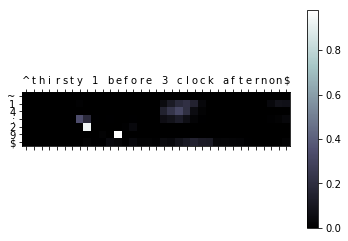

In [17]:
text = 'thirsty 1 before 3 clock afternon'
evaluate(model, text, src_c2ix, trg_ix2c)